In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
# Define hierarchical categories
categories = {
    "IAB1 Arts And Entertainment": ["IAB1_1_Books", "IAB1_5_Movies", "IAB1_6_Music"],
    "IAB2 Automotive": ["IAB2_11_Hatchback", "IAB2_14_MiniVan", "IAB2_15_Mororcycles", "IAB2_21_Trucks  Accessories"],
    "IAB3 Business": ["IAB3_6_Forestry"],
    "IAB17 Sports": ["IAB17_5_Boxing", "IAB17_6_CanoeING", "IAB17_7_Cheerleading", "IAB17_9_Cricket", "IAB17_11_Fly Fishing", "IAB17_12_Football", "IAB17_15_Golf", "IAB17_16_Horse Racing", "IAB17_29_Rugby", "IAB17_31_SailING", "IAB17_36_Snowboarding", "IAB17_37_Surfing", "IAB17_38_Swimming", "IAB17_39_Table Tennis", "IAB17_40_Tennis", "IAB17_41_Volleyball"]
}

In [3]:
# Data directories
train_dir = "/LAB/SGP-II/Dataset/train"
test_dir = "/LAB/SGP-II/Dataset/test"
val_dir = "/LAB/SGP-II/Dataset/val"

In [4]:
# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Learning rate
LEARNING_RATE = 0.001

In [5]:
# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 2313 images belonging to 24 classes.
Found 280 images belonging to 24 classes.
Found 311 images belonging to 24 classes.


In [6]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

2024-12-20 16:52:58.565729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 223 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-12-20 16:52:58.567600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21789 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6
2024-12-20 16:52:58.576451: I tensorflow/stream_executor/cuda/cuda_driver.cc:732] failed to allocate 223.88M (234749952 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [7]:
# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Train the model
with tf.device("/GPU:1"):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=100
    )

2024-12-20 16:53:06.799479: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2024-12-20 16:53:09.665393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


 4/73 [>.............................] - ETA: 3s - loss: 3.4911 - accuracy: 0.0625

2024-12-20 16:53:12.009945: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


73/73 [==============================] - 11s 87ms/step - loss: 3.3215 - accuracy: 0.0610 - val_loss: 3.1965 - val_accuracy: 0.0821
Epoch 2/100
73/73 [==============================] - 6s 75ms/step - loss: 3.0321 - accuracy: 0.1206 - val_loss: 2.9681 - val_accuracy: 0.1500
Epoch 3/100
73/73 [==============================] - 6s 78ms/step - loss: 2.8057 - accuracy: 0.1898 - val_loss: 2.7726 - val_accuracy: 0.2321
Epoch 4/100
73/73 [==============================] - 5s 75ms/step - loss: 2.6011 - accuracy: 0.2905 - val_loss: 2.5907 - val_accuracy: 0.3143
Epoch 5/100
73/73 [==============================] - 6s 77ms/step - loss: 2.4110 - accuracy: 0.3926 - val_loss: 2.4168 - val_accuracy: 0.3857
Epoch 6/100
73/73 [==============================] - 6s 75ms/step - loss: 2.2275 - accuracy: 0.4773 - val_loss: 2.2497 - val_accuracy: 0.4643
Epoch 7/100
73/73 [==============================] - 5s 74ms/step - loss: 2.0535 - accuracy: 0.5387 - val_loss: 2.0895 - val_accuracy: 0.5000
Epoch 8/100
73/73

In [9]:
# Evaluate the model
with tf.device("/GPU:1"):
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy}")

311/311 [==============================] - 3s 9ms/step - loss: 0.2860 - accuracy: 0.9132
Test Accuracy: 0.9131832718849182


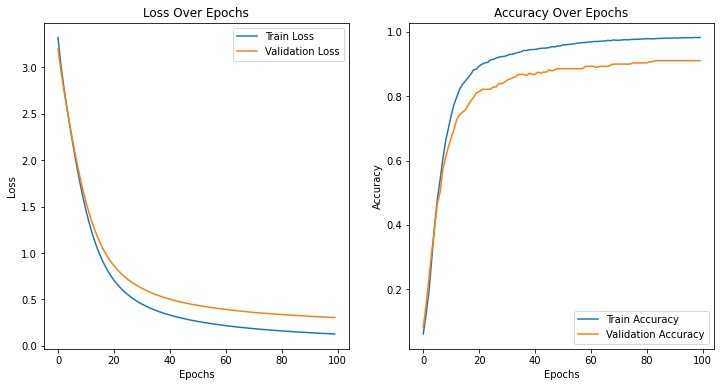

In [10]:
# Plot loss and accuracy
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.show()

plot_metrics(history)

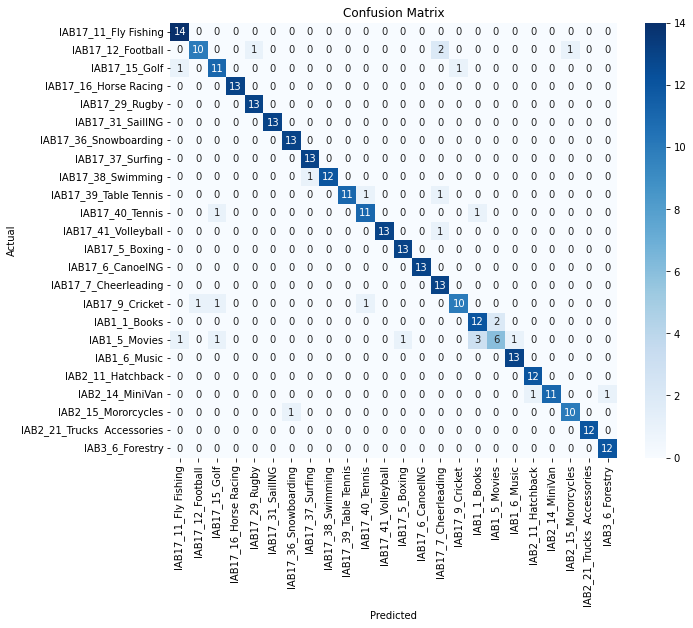

In [11]:
# Confusion matrix and classification report
with tf.device("/GPU:1"):
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
with tf.device("/GPU:1"):
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
                             precision    recall  f1-score   support

       IAB17_11_Fly Fishing       0.88      1.00      0.93        14
          IAB17_12_Football       0.91      0.71      0.80        14
              IAB17_15_Golf       0.79      0.85      0.81        13
      IAB17_16_Horse Racing       1.00      1.00      1.00        13
             IAB17_29_Rugby       0.93      1.00      0.96        13
           IAB17_31_SailING       1.00      1.00      1.00        13
      IAB17_36_Snowboarding       0.93      1.00      0.96        13
           IAB17_37_Surfing       0.93      1.00      0.96        13
          IAB17_38_Swimming       1.00      0.92      0.96        13
      IAB17_39_Table Tennis       1.00      0.85      0.92        13
            IAB17_40_Tennis       0.85      0.85      0.85        13
        IAB17_41_Volleyball       1.00      0.93      0.96        14
             IAB17_5_Boxing       0.93      1.00      0.96        13
          

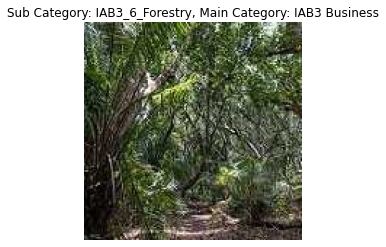

Sub Category: IAB3_6_Forestry
Main Category: IAB3 Business


In [13]:
# Predict a single image
with tf.device("/GPU:1"):
    def classify_image(image_path, model, categories):
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        image_processed = preprocess_input(image_resized)
        image_processed = np.expand_dims(image_processed, axis=0)

        prediction = model.predict(image_processed)
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_labels[predicted_class_index]

        parent_category = None
        for parent, subcategories in categories.items():
            if predicted_class in subcategories:
                parent_category = parent
                break

        plt.imshow(image_rgb)
        plt.title(f"Sub Category: {predicted_class}, Main Category: {parent_category}")
        plt.axis('off')
        plt.show()

        print(f"Sub Category: {predicted_class}")
        print(f"Main Category: {parent_category}")

    # Example usage
    image_path = "/LAB/SGP-II/Dataset/test/IAB3_6_Forestry/0OPLB3CCKO24.jpg"
    classify_image(image_path, model, categories)